# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.33KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

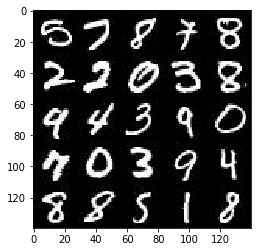

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

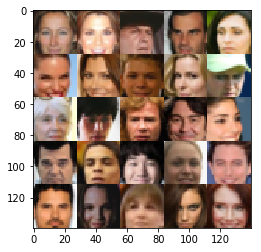

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    return (tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='real_input')
            , tf.placeholder(tf.float32, shape=[None, z_dim], name='z_input')
            , tf.placeholder(tf.float32, shape=[], name='learning_rate'))


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2 
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*256)
        
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    #tf.reset_default_graph()
    sample_z = np.random.uniform(-1, 1, size=(50, z_dim))
    steps = 0
    print_every = 10
    show_every = 100
    
    input_real, input_z, input_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2 
                
                _ = sess.run(d_opt, feed_dict={input_learning_rate: learning_rate, input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_learning_rate: learning_rate, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_learning_rate: learning_rate, input_z: batch_z})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_learning_rate: learning_rate, input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_learning_rate: learning_rate, input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 30, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6260... Generator Loss: 1.7232
Epoch 1/2... Discriminator Loss: 2.4778... Generator Loss: 0.4014
Epoch 1/2... Discriminator Loss: 1.1102... Generator Loss: 0.6394
Epoch 1/2... Discriminator Loss: 2.4691... Generator Loss: 0.1483
Epoch 1/2... Discriminator Loss: 1.2742... Generator Loss: 0.7213
Epoch 1/2... Discriminator Loss: 1.4577... Generator Loss: 0.3916
Epoch 1/2... Discriminator Loss: 1.9685... Generator Loss: 0.9892
Epoch 1/2... Discriminator Loss: 1.7964... Generator Loss: 0.6042
Epoch 1/2... Discriminator Loss: 1.4524... Generator Loss: 0.9467
Epoch 1/2... Discriminator Loss: 1.5226... Generator Loss: 0.4089


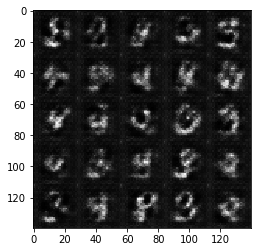

Epoch 1/2... Discriminator Loss: 1.2254... Generator Loss: 0.7553
Epoch 1/2... Discriminator Loss: 1.2698... Generator Loss: 0.5283
Epoch 1/2... Discriminator Loss: 1.4020... Generator Loss: 0.4373
Epoch 1/2... Discriminator Loss: 1.2596... Generator Loss: 0.6843
Epoch 1/2... Discriminator Loss: 1.1428... Generator Loss: 1.1932
Epoch 1/2... Discriminator Loss: 1.2592... Generator Loss: 0.7436
Epoch 1/2... Discriminator Loss: 1.3318... Generator Loss: 0.7879
Epoch 1/2... Discriminator Loss: 1.1854... Generator Loss: 1.4038
Epoch 1/2... Discriminator Loss: 1.3056... Generator Loss: 1.2578
Epoch 1/2... Discriminator Loss: 1.0311... Generator Loss: 0.9918


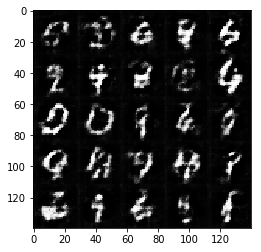

Epoch 1/2... Discriminator Loss: 1.1681... Generator Loss: 0.5577
Epoch 1/2... Discriminator Loss: 1.3870... Generator Loss: 1.5094
Epoch 1/2... Discriminator Loss: 1.4483... Generator Loss: 0.3868
Epoch 1/2... Discriminator Loss: 1.3544... Generator Loss: 2.0952
Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 0.6480
Epoch 1/2... Discriminator Loss: 1.4746... Generator Loss: 0.4197
Epoch 1/2... Discriminator Loss: 1.4617... Generator Loss: 0.5347
Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 0.5614
Epoch 1/2... Discriminator Loss: 1.2861... Generator Loss: 0.9219
Epoch 1/2... Discriminator Loss: 1.1693... Generator Loss: 0.7291


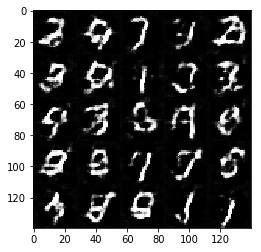

Epoch 1/2... Discriminator Loss: 1.4441... Generator Loss: 1.2379
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 1.2834... Generator Loss: 0.6513
Epoch 1/2... Discriminator Loss: 1.4656... Generator Loss: 0.6213
Epoch 1/2... Discriminator Loss: 1.3314... Generator Loss: 0.5078
Epoch 1/2... Discriminator Loss: 1.2131... Generator Loss: 0.7556
Epoch 1/2... Discriminator Loss: 1.2204... Generator Loss: 0.7320
Epoch 1/2... Discriminator Loss: 1.2614... Generator Loss: 0.7215
Epoch 1/2... Discriminator Loss: 1.3279... Generator Loss: 0.5123
Epoch 1/2... Discriminator Loss: 1.1490... Generator Loss: 0.7971


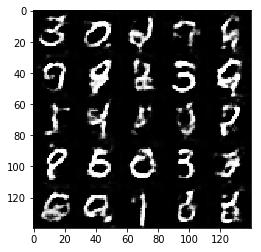

Epoch 1/2... Discriminator Loss: 1.2411... Generator Loss: 0.7183
Epoch 1/2... Discriminator Loss: 1.4923... Generator Loss: 1.1941
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 0.5659
Epoch 1/2... Discriminator Loss: 1.3067... Generator Loss: 0.4892
Epoch 1/2... Discriminator Loss: 1.5541... Generator Loss: 1.2724
Epoch 1/2... Discriminator Loss: 1.3934... Generator Loss: 0.5487
Epoch 1/2... Discriminator Loss: 1.2020... Generator Loss: 1.0842
Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 1.0804
Epoch 1/2... Discriminator Loss: 1.2424... Generator Loss: 0.7173
Epoch 1/2... Discriminator Loss: 1.3145... Generator Loss: 0.6452


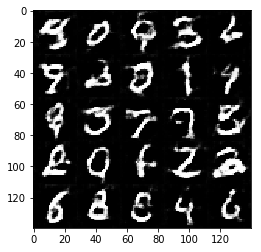

Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 0.5311
Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 0.8049
Epoch 1/2... Discriminator Loss: 1.2720... Generator Loss: 0.5651
Epoch 1/2... Discriminator Loss: 1.3167... Generator Loss: 0.8888
Epoch 1/2... Discriminator Loss: 1.7671... Generator Loss: 0.2318
Epoch 1/2... Discriminator Loss: 1.1044... Generator Loss: 0.7767
Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 0.9270
Epoch 1/2... Discriminator Loss: 1.0099... Generator Loss: 0.8818
Epoch 1/2... Discriminator Loss: 1.5117... Generator Loss: 0.2992
Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 0.5416


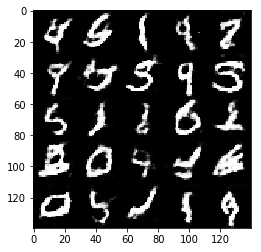

Epoch 1/2... Discriminator Loss: 1.4229... Generator Loss: 0.3874
Epoch 1/2... Discriminator Loss: 3.1314... Generator Loss: 0.0623
Epoch 1/2... Discriminator Loss: 1.1457... Generator Loss: 0.9540
Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 0.7538
Epoch 1/2... Discriminator Loss: 1.3130... Generator Loss: 0.5183
Epoch 1/2... Discriminator Loss: 1.6924... Generator Loss: 1.0827
Epoch 1/2... Discriminator Loss: 1.4725... Generator Loss: 0.5540
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 0.6332
Epoch 1/2... Discriminator Loss: 1.3890... Generator Loss: 0.9650
Epoch 1/2... Discriminator Loss: 1.2135... Generator Loss: 0.6552


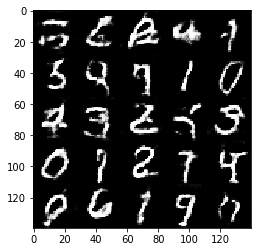

Epoch 1/2... Discriminator Loss: 2.0773... Generator Loss: 2.1911
Epoch 1/2... Discriminator Loss: 1.2131... Generator Loss: 0.6949
Epoch 1/2... Discriminator Loss: 1.5287... Generator Loss: 0.3176
Epoch 1/2... Discriminator Loss: 1.4121... Generator Loss: 0.4264
Epoch 1/2... Discriminator Loss: 1.5982... Generator Loss: 0.3755
Epoch 1/2... Discriminator Loss: 1.1888... Generator Loss: 0.7260
Epoch 1/2... Discriminator Loss: 2.1718... Generator Loss: 0.1480
Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.4649
Epoch 1/2... Discriminator Loss: 1.4567... Generator Loss: 0.3988
Epoch 1/2... Discriminator Loss: 1.3080... Generator Loss: 0.5832


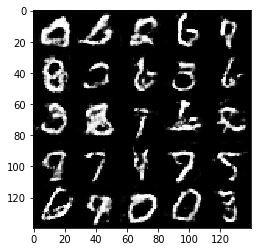

Epoch 1/2... Discriminator Loss: 1.1370... Generator Loss: 0.6597
Epoch 1/2... Discriminator Loss: 1.2672... Generator Loss: 0.5923
Epoch 1/2... Discriminator Loss: 1.7623... Generator Loss: 0.2513
Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 0.4760
Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 0.5823
Epoch 1/2... Discriminator Loss: 0.9698... Generator Loss: 1.0180
Epoch 1/2... Discriminator Loss: 1.2214... Generator Loss: 0.5047
Epoch 1/2... Discriminator Loss: 1.3153... Generator Loss: 0.5170
Epoch 1/2... Discriminator Loss: 1.7647... Generator Loss: 0.2499
Epoch 1/2... Discriminator Loss: 1.4617... Generator Loss: 0.3614


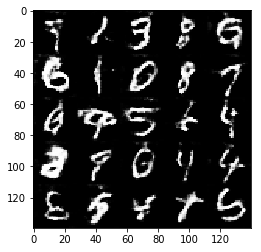

Epoch 1/2... Discriminator Loss: 1.2798... Generator Loss: 0.5155
Epoch 1/2... Discriminator Loss: 1.7752... Generator Loss: 0.2304
Epoch 1/2... Discriminator Loss: 1.1324... Generator Loss: 0.6006
Epoch 2/2... Discriminator Loss: 1.3600... Generator Loss: 0.4265
Epoch 2/2... Discriminator Loss: 4.5343... Generator Loss: 0.0175
Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 0.4866
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.4612
Epoch 2/2... Discriminator Loss: 1.4138... Generator Loss: 0.4226
Epoch 2/2... Discriminator Loss: 1.1437... Generator Loss: 1.1510
Epoch 2/2... Discriminator Loss: 1.0781... Generator Loss: 0.8342


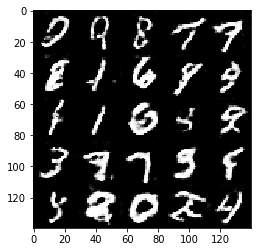

Epoch 2/2... Discriminator Loss: 1.1991... Generator Loss: 0.5933
Epoch 2/2... Discriminator Loss: 1.5863... Generator Loss: 0.2972
Epoch 2/2... Discriminator Loss: 1.4917... Generator Loss: 0.3875
Epoch 2/2... Discriminator Loss: 1.1345... Generator Loss: 0.5507
Epoch 2/2... Discriminator Loss: 0.9137... Generator Loss: 0.8846
Epoch 2/2... Discriminator Loss: 1.0073... Generator Loss: 0.7334
Epoch 2/2... Discriminator Loss: 1.7066... Generator Loss: 1.2854
Epoch 2/2... Discriminator Loss: 1.1696... Generator Loss: 0.6489
Epoch 2/2... Discriminator Loss: 1.3692... Generator Loss: 0.4140
Epoch 2/2... Discriminator Loss: 1.7441... Generator Loss: 0.2576


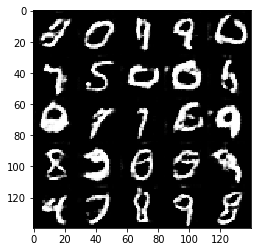

Epoch 2/2... Discriminator Loss: 1.6965... Generator Loss: 0.2837
Epoch 2/2... Discriminator Loss: 1.0121... Generator Loss: 0.7761
Epoch 2/2... Discriminator Loss: 1.1713... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 0.7696... Generator Loss: 1.9749
Epoch 2/2... Discriminator Loss: 1.3621... Generator Loss: 0.3939
Epoch 2/2... Discriminator Loss: 1.0180... Generator Loss: 1.3528
Epoch 2/2... Discriminator Loss: 1.4302... Generator Loss: 0.3769
Epoch 2/2... Discriminator Loss: 1.6020... Generator Loss: 0.3161
Epoch 2/2... Discriminator Loss: 1.1863... Generator Loss: 0.4847
Epoch 2/2... Discriminator Loss: 1.9870... Generator Loss: 2.1805


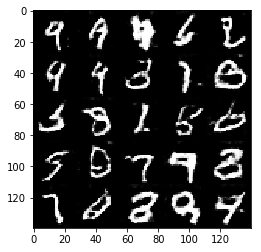

Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 0.8702
Epoch 2/2... Discriminator Loss: 0.9731... Generator Loss: 0.7509
Epoch 2/2... Discriminator Loss: 1.4764... Generator Loss: 0.3984
Epoch 2/2... Discriminator Loss: 1.1750... Generator Loss: 0.6937
Epoch 2/2... Discriminator Loss: 1.2762... Generator Loss: 0.4803
Epoch 2/2... Discriminator Loss: 1.5906... Generator Loss: 0.3405
Epoch 2/2... Discriminator Loss: 1.2879... Generator Loss: 0.4901
Epoch 2/2... Discriminator Loss: 1.2891... Generator Loss: 0.5203
Epoch 2/2... Discriminator Loss: 1.0360... Generator Loss: 0.6444
Epoch 2/2... Discriminator Loss: 0.9686... Generator Loss: 1.2310


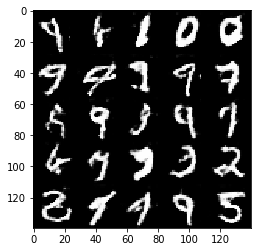

Epoch 2/2... Discriminator Loss: 1.1746... Generator Loss: 0.6933
Epoch 2/2... Discriminator Loss: 1.1888... Generator Loss: 0.5394
Epoch 2/2... Discriminator Loss: 1.0587... Generator Loss: 0.8861
Epoch 2/2... Discriminator Loss: 1.2880... Generator Loss: 1.1952
Epoch 2/2... Discriminator Loss: 1.3493... Generator Loss: 0.4557
Epoch 2/2... Discriminator Loss: 1.3698... Generator Loss: 1.8338
Epoch 2/2... Discriminator Loss: 1.5685... Generator Loss: 0.3025
Epoch 2/2... Discriminator Loss: 0.9170... Generator Loss: 0.8588
Epoch 2/2... Discriminator Loss: 0.9432... Generator Loss: 0.7001
Epoch 2/2... Discriminator Loss: 1.2127... Generator Loss: 0.4853


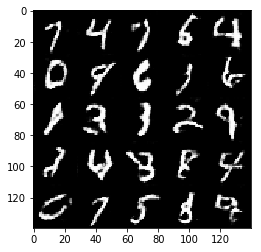

Epoch 2/2... Discriminator Loss: 3.9692... Generator Loss: 0.0259
Epoch 2/2... Discriminator Loss: 1.4756... Generator Loss: 0.3484
Epoch 2/2... Discriminator Loss: 1.0151... Generator Loss: 0.6835
Epoch 2/2... Discriminator Loss: 0.9610... Generator Loss: 0.9654
Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 0.5299
Epoch 2/2... Discriminator Loss: 0.7034... Generator Loss: 1.2304
Epoch 2/2... Discriminator Loss: 1.0721... Generator Loss: 0.5912
Epoch 2/2... Discriminator Loss: 0.9459... Generator Loss: 0.7232
Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 1.0264
Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 0.4699


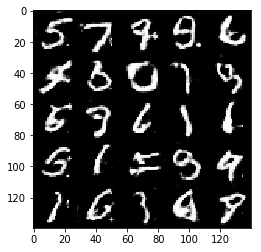

Epoch 2/2... Discriminator Loss: 1.8340... Generator Loss: 0.2289
Epoch 2/2... Discriminator Loss: 0.7881... Generator Loss: 1.3920
Epoch 2/2... Discriminator Loss: 1.0952... Generator Loss: 0.9527
Epoch 2/2... Discriminator Loss: 1.1618... Generator Loss: 0.5573
Epoch 2/2... Discriminator Loss: 1.1821... Generator Loss: 0.5301
Epoch 2/2... Discriminator Loss: 1.7211... Generator Loss: 0.2804
Epoch 2/2... Discriminator Loss: 0.9588... Generator Loss: 0.6811
Epoch 2/2... Discriminator Loss: 0.8222... Generator Loss: 1.1247
Epoch 2/2... Discriminator Loss: 1.3933... Generator Loss: 0.5169
Epoch 2/2... Discriminator Loss: 1.2562... Generator Loss: 0.5511


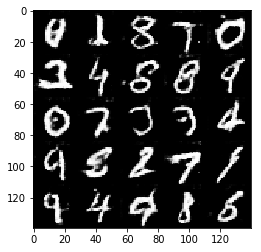

Epoch 2/2... Discriminator Loss: 0.8481... Generator Loss: 0.7643
Epoch 2/2... Discriminator Loss: 1.4243... Generator Loss: 0.4805
Epoch 2/2... Discriminator Loss: 2.1687... Generator Loss: 0.1965
Epoch 2/2... Discriminator Loss: 1.4439... Generator Loss: 0.3883
Epoch 2/2... Discriminator Loss: 1.1272... Generator Loss: 1.2980
Epoch 2/2... Discriminator Loss: 1.7399... Generator Loss: 0.2639
Epoch 2/2... Discriminator Loss: 1.2248... Generator Loss: 0.5780
Epoch 2/2... Discriminator Loss: 1.1883... Generator Loss: 0.5043
Epoch 2/2... Discriminator Loss: 1.0749... Generator Loss: 0.6763
Epoch 2/2... Discriminator Loss: 1.0992... Generator Loss: 0.5769


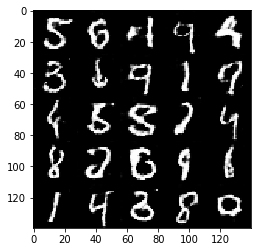

Epoch 2/2... Discriminator Loss: 0.9379... Generator Loss: 0.7252
Epoch 2/2... Discriminator Loss: 0.8137... Generator Loss: 0.8560
Epoch 2/2... Discriminator Loss: 2.0947... Generator Loss: 0.1969
Epoch 2/2... Discriminator Loss: 1.0665... Generator Loss: 0.5605
Epoch 2/2... Discriminator Loss: 1.0311... Generator Loss: 0.6813
Epoch 2/2... Discriminator Loss: 0.9440... Generator Loss: 1.4010
Epoch 2/2... Discriminator Loss: 0.8726... Generator Loss: 0.8332
Epoch 2/2... Discriminator Loss: 1.3684... Generator Loss: 2.4651
Epoch 2/2... Discriminator Loss: 0.8320... Generator Loss: 0.9702
Epoch 2/2... Discriminator Loss: 1.2989... Generator Loss: 0.4491


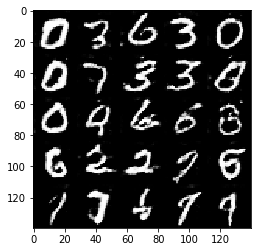

Epoch 2/2... Discriminator Loss: 0.9806... Generator Loss: 0.8360
Epoch 2/2... Discriminator Loss: 1.5102... Generator Loss: 0.3285
Epoch 2/2... Discriminator Loss: 1.4079... Generator Loss: 0.5067
Epoch 2/2... Discriminator Loss: 1.0365... Generator Loss: 0.7505
Epoch 2/2... Discriminator Loss: 1.3205... Generator Loss: 0.5172
Epoch 2/2... Discriminator Loss: 1.0522... Generator Loss: 0.8840
Epoch 2/2... Discriminator Loss: 1.0599... Generator Loss: 0.8836


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 3.6394
Epoch 1/1... Discriminator Loss: 2.3751... Generator Loss: 7.1329
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 1.4615
Epoch 1/1... Discriminator Loss: 2.8563... Generator Loss: 0.0955
Epoch 1/1... Discriminator Loss: 1.7598... Generator Loss: 1.7065
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 1.1669
Epoch 1/1... Discriminator Loss: 1.7700... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 1.2499
Epoch 1/1... Discriminator Loss: 2.2472... Generator Loss: 0.5015


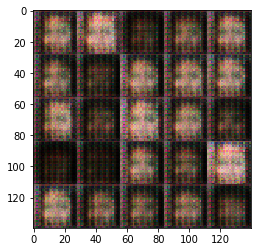

Epoch 1/1... Discriminator Loss: 2.3170... Generator Loss: 0.2704
Epoch 1/1... Discriminator Loss: 1.5990... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.5435... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 1.2724
Epoch 1/1... Discriminator Loss: 2.6308... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.6789... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.8752


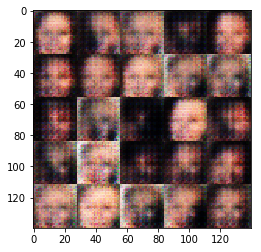

Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.6489... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7408
Epoch 1/1... Discriminator Loss: 1.7189... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.4762... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.6418... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.5075... Generator Loss: 0.7179


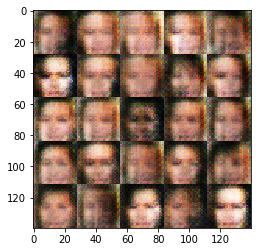

Epoch 1/1... Discriminator Loss: 1.1779... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.5570... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.5554... Generator Loss: 0.5564
Epoch 1/1... Discriminator Loss: 1.7024... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.7422


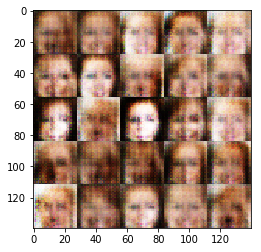

Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.7123... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.6208... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.8043... Generator Loss: 0.4224


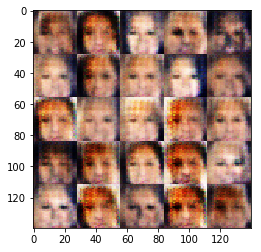

Epoch 1/1... Discriminator Loss: 1.4901... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.6841... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.7620


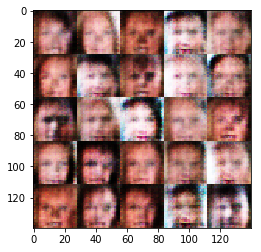

Epoch 1/1... Discriminator Loss: 1.4703... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.9324... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.6812... Generator Loss: 0.5782
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.6787


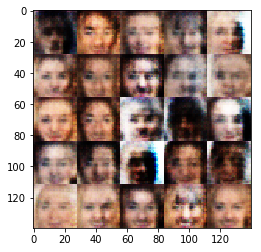

Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.7537... Generator Loss: 0.5667
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.5684... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 1.6000... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.5352... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.6446


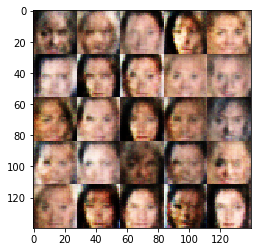

Epoch 1/1... Discriminator Loss: 1.7220... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.6638... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.5826
Epoch 1/1... Discriminator Loss: 1.3517... Generator Loss: 0.7620


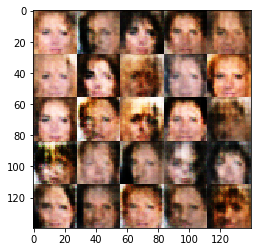

Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.5036... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.5261... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.6194


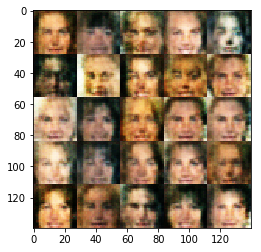

Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.5018... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.5674... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.6309
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7084


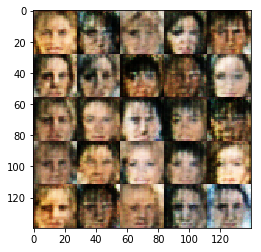

Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.5197... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.5553... Generator Loss: 0.6468


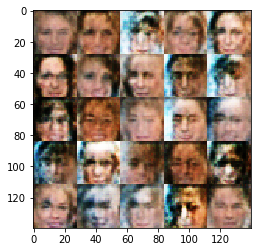

Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.6245
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.6818
Epoch 1/1... Discriminator Loss: 1.5700... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.5117... Generator Loss: 0.6899


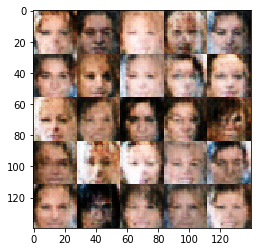

Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.5532... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.5008... Generator Loss: 0.6027


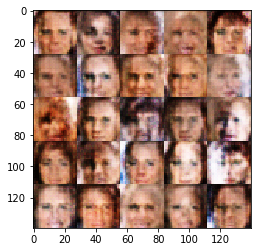

Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6407
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.6008... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7248


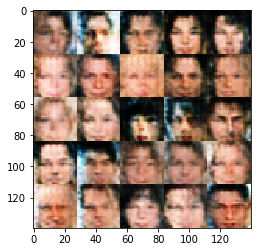

Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.6866


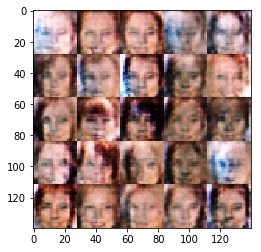

Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 0.6297


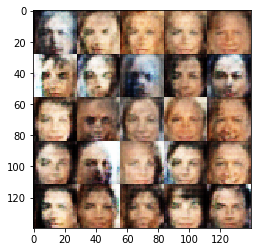

Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4757... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.5885... Generator Loss: 0.5664


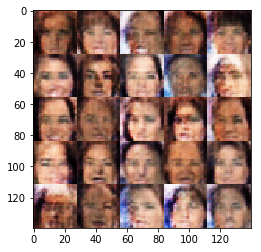

Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.4848... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.4222... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.5853... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.6259


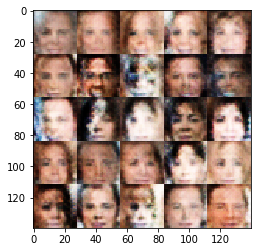

Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.5078... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.6491
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.6206


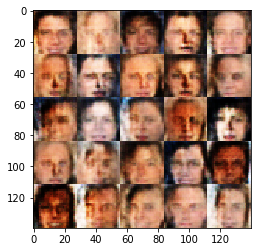

Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.5560... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.7445


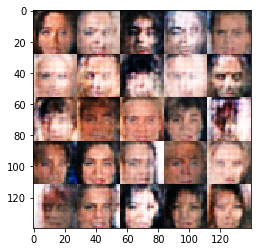

Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.5878
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.6246


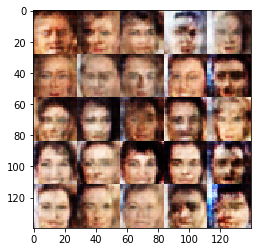

Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.4751... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.4081... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.4884
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.6178... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.5946


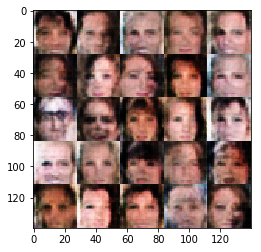

Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.6705
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.6118


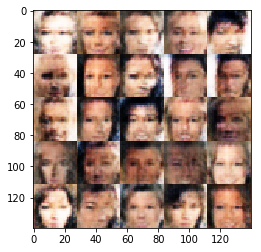

Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.5803
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.6527


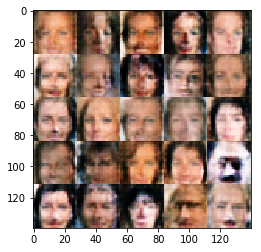

Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 0.6412


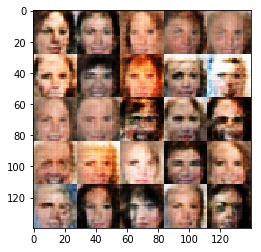

Epoch 1/1... Discriminator Loss: 1.5380... Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.5926
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.6875


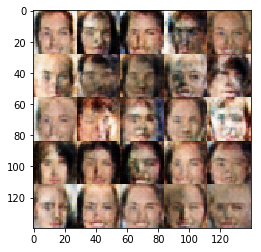

Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.4836... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.6191... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.5637... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.5718... Generator Loss: 0.5565
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.5536... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.6644


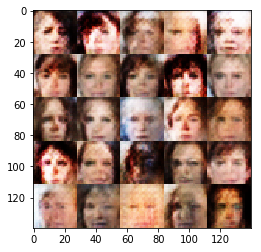

Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.5212... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7115


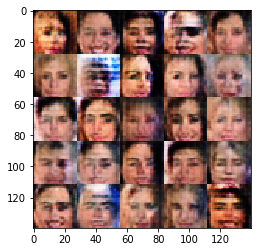

Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6599
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.6602
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.5781


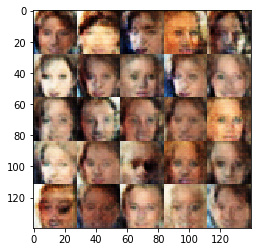

Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.3543... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.4475... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.4859... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.6165


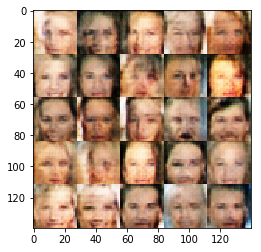

Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6885
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.6338
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.6505


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.